# Model Training (Random Forest)

In [99]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.ensemble import RandomForestRegressor
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from joblib import dump
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from scipy.stats import uniform
import os 

In [101]:
DATA_PATH = '../data/processed/airfoil_transformed.csv'

In [103]:
df =pd.read_csv(DATA_PATH)

In [105]:
selected_features = [
    'frequency',
    'suction-side-displacement-thickness',
    'chord-length'
]

In [107]:
x = df[selected_features]
y = df['scaled-sound-pressure']

In [109]:
x_train , x_test ,y_train , y_test = train_test_split(x,y,test_size=0.2, random_state=42)

# Scaling

In [112]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Random Forest Modeling

In [115]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10,random_state=42)
rf_model.fit(x_train_scaled , y_train)

RandomForestRegressor(max_depth=10, random_state=42)

# Predict

In [118]:
y_pred = rf_model.predict(x_test_scaled)

In [120]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("R2 Skoru:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))


R2 Skoru: 0.8974898440626446
MAE: 1.643327056535794
MSE: 5.135613040829278


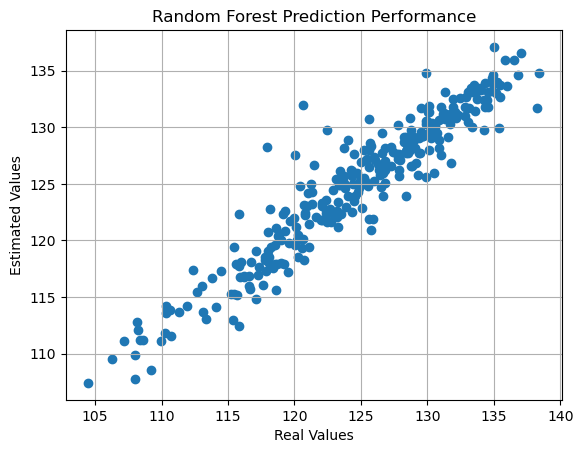

In [149]:

plt.scatter(y_test, y_pred)
plt.xlabel("Real Values")
plt.ylabel("Estimated Values")
plt.title("Random Forest Prediction Performance")
plt.grid(True)
plt.show()


# Cross-Verification

In [151]:
scores = cross_val_score(rf_model,x,y,cv=5,scoring='r2')

print(f"R2 scores in each layer:{scores}")
print(f"Cross-verification R2 average:{scores.mean():.4f}")
print(f"Cross-verification R2 standard deviation:{scores.std():.4f}")

R2 scores in each layer:[0.80523277 0.80563111 0.64670432 0.55641248 0.6248602 ]
Cross-verification R2 average:0.6878
Cross-verification R2 standard deviation:0.1006


# Hyperparameter Optimization with RandomizedSearchCV

In [153]:
rf = RandomForestRegressor(random_state=42)

param_distributions = {
    'n_estimators': randint(100,500),
    'max_features': ['sqrt','log2',0.6,0.8],
    'max_depth': randint(10,50),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50, 
    cv=5,      
    scoring='r2',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

random_search.fit(x_train, y_train)


print(f"The best hyperparameters: {random_search.best_params_}")
print(f"Best cross-verification R2 score: {random_search.best_score_:.4f}")


best_rf_model = random_search.best_estimator_


test_r2_score = best_rf_model.score(x_test, y_test)
print(f"Test set R2 score of optimised model: {test_r2_score:.4f}")


y_pred = best_rf_model.predict(x_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
The best hyperparameters: {'bootstrap': False, 'max_depth': 39, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 413}
Best cross-verification R2 score: 0.8839
Test set R2 score of optimised model: 0.8963


In [155]:
os.makedirs('models/trained_models', exist_ok=True)
print("Folder structure created: 'models/trained_models'")

model_path = 'models/trained_models/random_forest_airfoil_model.pkl'
dump(best_rf_model, model_path)
print(f"Model başarıyla kaydedildi: {model_path}")

Folder structure created: 'models/trained_models'
Model başarıyla kaydedildi: models/trained_models/random_forest_airfoil_model.pkl
